# Perkenalan

Nama: Zaky Rizky Akbar

Batch: HCK-026

Objective: Membuat model ANN Natural Language Processing (NLP) tentang sentiment analysis TripAdvisor dengan metrics yang digunakan recall. Tujuannya untuk dapat menentukan apakah sebuah review memiliki sentiment positif, negatif, atau neutral.

[Link Dataset](https://drive.google.com/file/d/1StNJirVisMkgs0uCjic2mAD5gVSFMdKh/view?usp=sharing)

# Import Libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordninja
import tensorflow as tf
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')


In [3]:
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [4]:
df.tail(10)

,Review,Rating
20481,ok price look hotel ok little run average clea...,2
20482,great choice wife chose best western quite bit...,5
20483,good bed clean convenient just night happy sta...,4
20484,deceptive staff deceptive desk staff claiming ...,2
20485,not impressed unfriendly staff checked asked h...,2
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Dataframe ini memiliki 2 feature, `Review` dan `Rating`. Tipe data dari masing-masing feature adalah object dan int.

In [6]:
df.shape

(20491, 2)

Dataframe ini memiliki 20491 row dan 2 columns.

In [7]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

Dataset ini tidak memiliki missing value.

In [8]:
df.duplicated().sum()

0

Dataset ini tidak memiliki data duplikat.

# Exploratory Data Analysis

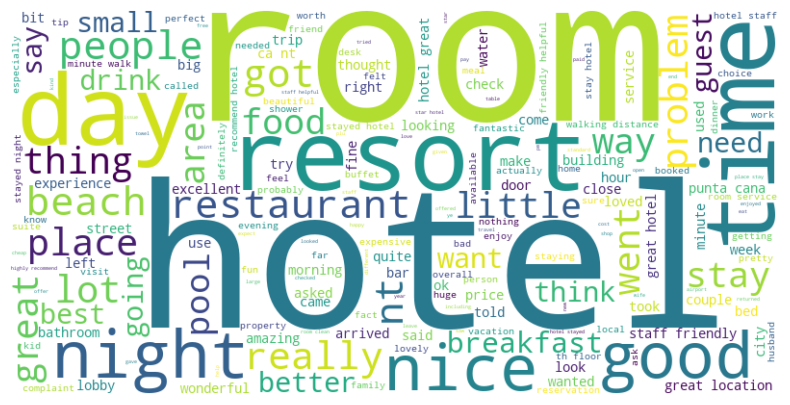

In [9]:
wc = df['Review']

# Start with one review:
text = " ".join(wc.astype(str))

# Clean text: lowercase, remove HTML-like tags and non-alphabetic characters
text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags like <br>, <div>, etc.
text = re.sub(r'\bbr\b', ' ', text)  # remove isolated 'br'
text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
text = text.lower()

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Jika kita lihat dari wordcloud, kata-kata seperti 'room', 'hotel', 'night', 'resort', 'restaurant', dan 'nice' menjadi beberapa kata-kata yang sering kali muncul dalam sebuah review. Jika kita lihat sekilas, wordcloud ini didominasi oleh kata-kata yang sifatnya menjelaskan tentang room dan hotel (karena memang dataset ini tentang hotel), ataupun nice dan wonderful, yang menggambarkan sentiment yang pada umumnya positif. Sedangkan kata-kata seperti 'bad', 'complaint' relatif kecil ataupun jarang. Ini artinya jika kita melihat wordcloud yang dihasilkan, mostly diisi oleh sentiment positif.

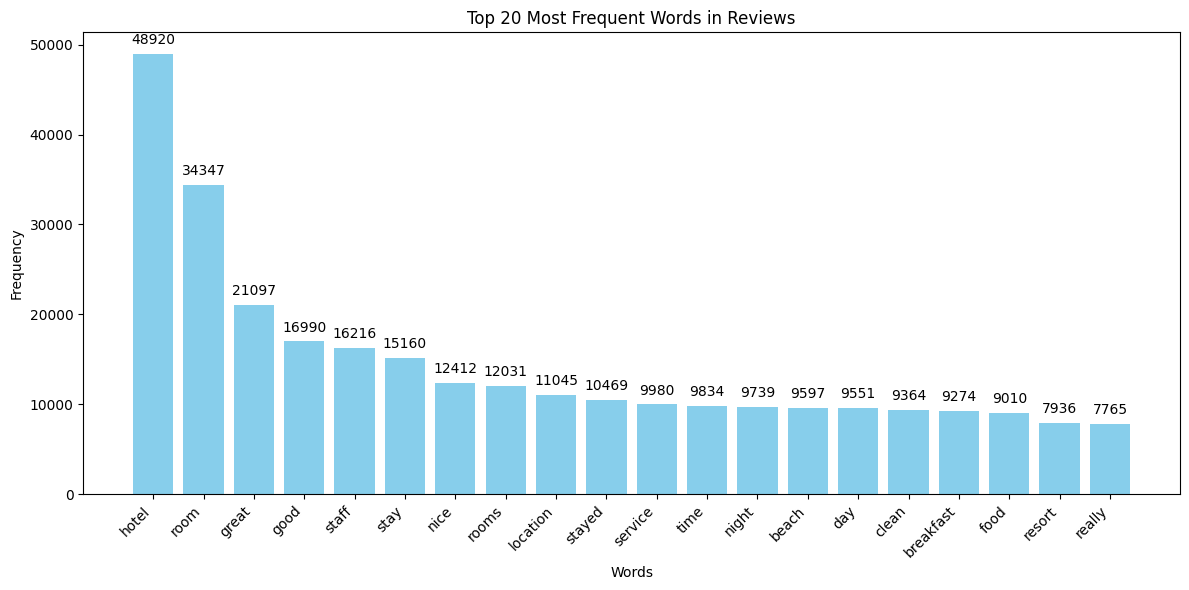

In [10]:
wc = df['Review']

# Join them into a single string
text = " ".join(wc.astype(str))

# Clean text: lowercase, remove HTML-like tags and non-alphabetic characters
text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags like <br>, <div>, etc.
text = re.sub(r'\bbr\b', ' ', text)  # remove isolated 'br'
text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
text = re.sub(r'\bnt\b', ' ', text)  # remove isolated 'nt'
text = text.lower()


# Tokenize words
words = text.split()

# Remove common stopwords
filtered_words = [word for word in words if word not in STOPWORDS]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the 20 most common words
top_20 = word_counts.most_common(20)
words, counts = zip(*top_20)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Words in Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")

# Add annotations
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.annotate(f'{count}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # offset text by 5 points above bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

Pada barchart ini, kita melihat 20 kata yang sering muncul. Karena kita mengumpulkan seluruh review, maka mayoritas diisi oleh kata-kata yang memiliki sentiment positif. Tetapi, dari 20 kata yang sering muncul, hanya 4 yang memiliki konotasi positif, atau menunjukan sentiment positif, yaitu, 'great', 'good', 'nice', dan 'clean'. Sedangkan sisanya diisi oleh hal-hal yang berhubunguan dengan hotel.

Itu dibuktikan dengan 16 kata lainnya yang berhubungan dengan hotel. Bisa dilihat dari 2 kata pertama yang sering muncul, yaitu 'hotel' dan 'room'.

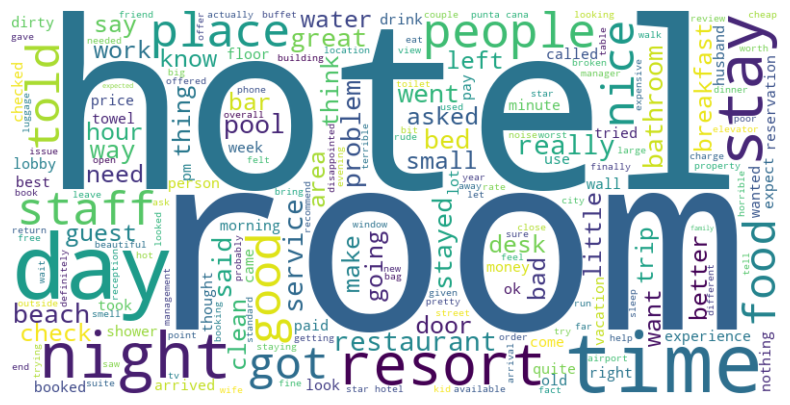

In [11]:
# Filter only low-rated reviews (rating 1 or 2)
low_rated_reviews = df[df['Rating'].isin([1, 2])]['Review']

# Combine into one text string
text = " ".join(low_rated_reviews.astype(str))

# Clean text
text = re.sub(r'<.*?>', ' ', text)
text = re.sub(r'\bbr\b', ' ', text)
text = re.sub(r'[^a-zA-Z\s]', '', text)
text = re.sub(r'\bnt\b', ' ', text)  
text = text.lower()

# Generate word cloud
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis("off")
plt.show()

Setelah melihat wordcloud secara keseluruhan, kita akan mencoba untuk melihat wordcloud untuk rating 1-2. Rating 1-2 identik dengan rating yang buruk, sehingga kemungkinan sentiment yang dihasilkan akan negatif. Tetapi, kata-kata yang seperti 'room', 'hotel', dan 'resort' juga muncul pada review dengan rating 1-2. Bisa jadi, kata-kata ini muncul karena membahas room ataupun hotel yang tidak sesuai harapan atau ekspektasi dari customer.

Kita juga bisa melihat bahwa pada wordcloud dengan rating 1-2, kata-kata seperti 'problem', 'bad', dan 'dirty' cukup sering muncul. Lalu kata-kata seperti 'rude' dan 'horrible' juga muncul, walaupun kita bisa menerka bahwa frekuensinya kemungkinan cukup jarang, karena size yang dihasilkan oleh wordcloud kecil dibandingkan dengan kata-kata lainnya.

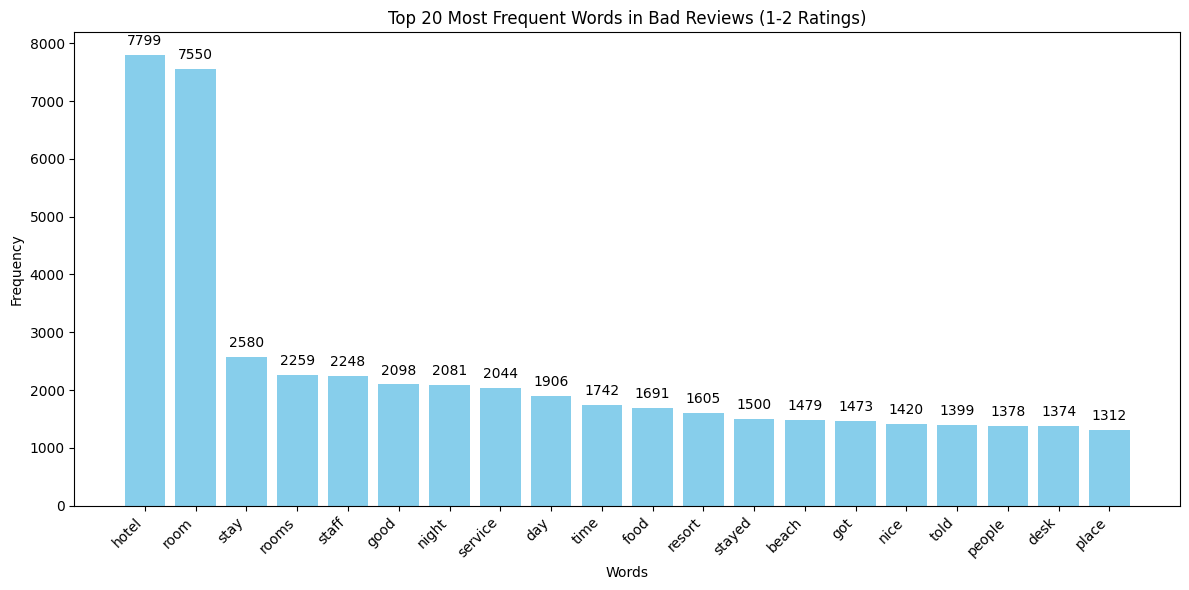

In [12]:
# Filter only low-rated reviews (rating 1 or 2)
low_rated_reviews = df[df['Rating'].isin([1, 2])]['Review']

# Join them into a single string
text = " ".join(low_rated_reviews.astype(str))

# Clean text: lowercase, remove HTML-like tags and non-alphabetic characters
text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags like <br>, <div>, etc.
text = re.sub(r'\bbr\b', ' ', text)  # remove isolated 'br'
text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
text = re.sub(r'\bnt\b', ' ', text)  # remove isolated 'nt'
text = text.lower()


# Tokenize words
words = text.split()

# Remove common stopwords
filtered_words = [word for word in words if word not in STOPWORDS]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the 20 most common words
top_20 = word_counts.most_common(20)
words, counts = zip(*top_20)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Words in Bad Reviews (1-2 Ratings)")
plt.xlabel("Words")
plt.ylabel("Frequency")

# Add annotations
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.annotate(f'{count}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # offset text by 5 points above bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

Jika kita lihat distribusi dari 20 kata yang sering muncul dari review dengan rating 1-2, kita melihat bahwa 'hotel' dan 'room' menjadi 2 kata yang sering kali muncul. Karena kita melakukan filter kata-kata yang muncul pada rating 1-2, maka ada kemungkinan bahwa meskipun hotel dan room 2 kata yang paling sering muncul, tetapi bisa jadi membahas tentang ketidakpuasan customer terhadap hotel tersebut ataupun room yang mereka tempati.

Secara keseluruhan, 20 kata yang sering muncul pada review dengan rating 1-2 memiliki kemiripan. Tetapi, bisa jadi yang membedakan antara keduanya adalah konteks.

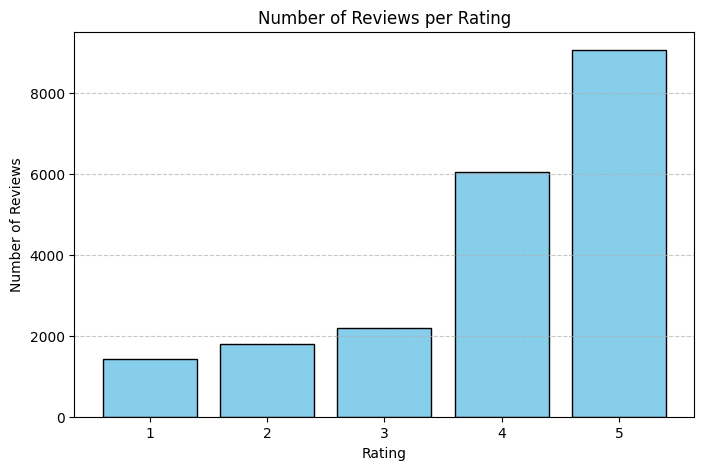

In [13]:
# Count the frequency of each rating
rating_counts = df['Rating'].value_counts().sort_index()

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
plt.title("Number of Reviews per Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.xticks([1, 2, 3, 4, 5])  # Ensure all ratings are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Jika kita melihat persebaran rating, maka rating 5 menjadi yang paling banyak dan rating 1 menjadi yang paling sedikit. Bisa dilihat bahwa semakin tinggi ratingnya, semakin tinggi juga jumlah reviewnya.

Melihat graph ini, kita bisa mengatakan bahwa datanya tidak balance antara rating yang bagus dan yang tidak bagus.

# Text Preprocessing

In [14]:
stpwds_en = set(stopwords.words('english'))
# Manually remove 'not' from stopwords to preserve it
stpwds_en.discard('not')

lemmatizer = WordNetLemmatizer()

Kita akan menggunakan stopwords parameter 'english' dan menghilangkan kata 'not' dalam stopwords. Lalu kita akan menggunakan lemmatizer untuk mengubah setiap kata ke dalam bentuk dasarnya, sehingga kata-kata seperti 'running', 'ran', dan 'runs' akan diubah menjadi 'run'. Contoh lainnya adalah 'ate', 'eating', dan 'eaten' menjadi 'eat'.

Selain itu, alasan menggunakan lemmatizer ketimbang stemmer adalah lemmatizer mempertimbangkan *Part-of-Speech* (POS) sehingga lebih kontekstual, sedangkan stemmer tidak mempertimbangkan POS dan terkadang menghilangkan beberapa kata tanpa konteks grammar yang benar.

In [15]:
def text_preprocessing(text):
    # Lowercase
    text = text.lower()

    # Remove HTML
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\bbr\b', ' ', text)

    # Convert "4*" to "4-star" if it's followed by space or end of string
    text = re.sub(r'\b(\d)\*(?=\s|$)', r'\1 star', text)

    # Fix contractions: convert "ca n't" → "cant", "do n't" → "dont"
    text = re.sub(r"\b(ca|do|does|did|is|are|was|were|should|would|could|must|has|have|had|might|will|wo)\s+n['’]t\b", lambda m: m.group(1) + "nt", text)
    
    # Convert standalone n't to "not"
    text = re.sub(r"\b[nN]['’]t\b", "not", text)  # rare case like just "n't"
    text = re.sub(r"\b(\w+)n['’]t\b", r"\1nt", text)  # e.g., wasn't → wasnt

    # Remove non-alphanumeric characters except apostrophes (keep for now)
    text = re.sub(r"[^\w\s]", '', text)

    # Tokenize
    words = word_tokenize(text)

    # Split merged words using wordninja
    split_words = []
    for word in words:
        if re.fullmatch(r'(?:[1-9]|[1-9]\d)(?:st|nd|rd|th)', word):
            split_words.append(word)
        else:
            split_words.extend(wordninja.split(word))

    # Remove stopwords (except 'not') and lemmatize
    final_words = [lemmatizer.lemmatize(w) for w in split_words if w not in stpwds_en]

    return " ".join(final_words)

Pada proses preprocessing, kita akan menghilangkan tanda baca, element html (jika ada), mengganti asterisk ('*') menjadi star (karena ada satu review yang menggunakan *), menggabungkan token 'ca' dan 'n't' menjadi 'cant', selain itu merubah n't menjadi not (ada kemungkinan typo), dan melakukan word slicing menggunakan wordninja, karena ada beberapa kata yang tergabung menjadi 1, meskipun artinya berbeda masing-masing.

Kita juga memberikan condition jika ada kata-kata yang tergabung seperti 1st, 2nd, 3rd, 4th, etc. Maka jangan dipisahkan. Selain condition tadi, maka kita bisa memisahkan kata-kata yang tergabung dengan menggunakan wordninja.

In [16]:
# Applying the function to fix split contractions in the 'Review' column
df['Review_Processed'] = df['Review'].apply(lambda x: text_preprocessing(x))


df

,Review,Rating,Review_Processed
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room not 4 star experience hotel monaco s...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went sea hawk game aweso...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret 3rd time staying charm not 5 ...
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff not par...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...


In [17]:
print("Original:", df.loc[20486, 'Review'])

Original: best kept secret 3rd time staying charm, not 5-star ca n't beat, time stayed increased esteem, bw caters business crowd stayed leisure usually weekend, rate perfect, clean green request available drop-dead view space needle practically street, ask check-in make sure, mere walk belltown 5 short blocks choices restaurants wine spirits bars younger folks clubs live music pubs jazz clubs weather permits nice hoof pike, n't usual bw complimentary continental breakfast buffet b/c rates lower splurge breakfast room service, parking free lower locked parking cameras felt cool leaving shopping finds great shopping city discretely tucked away suv, check money not long best kept secret status longer, kudos staff management property,  


In [18]:
print("Processed:", df.loc[20486, 'Review_Processed'])

Processed: best kept secret 3rd time staying charm not 5 star cant beat time stayed increased esteem b w caters business crowd stayed leisure usually weekend rate perfect clean green request available drop dead view space needle practically street ask check make sure mere walk bell town 5 short block choice restaurant wine spirit bar younger folk club live music pub jazz club weather permit nice hoof pike not usual b w complimentary continental breakfast buffet bc rate lower splurge breakfast room service parking free lower locked parking camera felt cool leaving shopping find great shopping city discrete ly tucked away suv check money not long best kept secret status longer kudos staff management property


In [19]:
print("Original:", df.loc[20490, 'Review'])

Original: people talking, ca n't believe excellent ratings hotel, just n't, yes patricia extremely helpful fluent languages goes way make welcome, said place bit dump, inexpensive hotel expensive city place bit dated institutional odor charm funeral home, walking steps hotel girlfriend step condom yes condom steps, lots guys hanging desk hallway, girlfriend swears house prostitution, patricia did arrange taxi following morning stayed night did wrong information cost fare, rooms clean large bathroom small, passable night glad leave following morning not recommend extended stay unless tight budget n't care look feel place,  


In [20]:
print("Processed:", df.loc[20490, 'Review_Processed'])

Processed: people talking cant believe excellent rating hotel not yes patricia extremely helpful fluent language go way make welcome said place bit dump inexpensive hotel expensive city place bit dated institutional odor charm funeral home walking step hotel girlfriend step condom yes condom step lot guy hanging desk hallway girlfriend swears house prostitution patricia arrange taxi following morning stayed night wrong information cost fare room clean large bathroom small passable night glad leave following morning not recommend extended stay unless tight budget not care look feel place


In [21]:
print("Original:", df.loc[2, 'Review'])

Original: nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermost

In [22]:
print("Processed:", df.loc[2, 'Review_Processed'])

Processed: nice room not 4 star experience hotel monaco seattle good hotel not 4 star level positive large bathroom mediterranean suite comfortable bed pillow attentive housekeeping staff negative ac unit malfunctioned stay desk disorganized missed 3 separate wake call concierge busy hard touch didnt provide guidance special request tv hard use ipod sound dock suite non functioning decided book mediterranean suite 3 night weekend stay 1st choice rest party filled comparison w spent 45 night larger square footage room great soaking tub whirlpool jet nice shower stay hotel arrange car service price 53 tip reasonable driver waiting arrival check easy downside room picked 2 person jac uzi tub bath accessory salt bubble bath didnt stay night got 121 checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointing morning way asked desk check thermostat said 65 f 74 2 degree warm 

Setelah dilakukan preprocessing text, bisa dilihat ada perubahan antara review original dan yang sudah diproses dengan menggunakan regex (regular expression). Selain itu dengan menggunakan package wordninja dapat menslicing kata-kata yang tergabung seperti 'pillowsattentive' dan 'staffnegative'.

# Target Conversion

In [23]:
# Sample ratings
ratings = df['Rating'].tolist()

# Define the function
def get_sentiment_label(rating):
    if rating >= 4:
        return 1  # Positive
    elif rating == 3:
        return 2  # Neutral
    else:
        return 0  # Negative

# Apply the target conversion and create a new column 'sentiment'
df['Sentiment'] = df['Rating'].apply(get_sentiment_label)

df

,Review,Rating,Review_Processed,Sentiment
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room not 4 star experience hotel monaco s...,2
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,1
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went sea hawk game aweso...,1
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret 3rd time staying charm not 5 ...,1
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...,1
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff not par...,0
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...,0


Karena kita tidak mempunyai feature `Sentiment`, maka kita akan membuat feature baru dengan labeling 0 sebagai negative, 1 sebagai positive, dan 2 sebagai neutral.

In [24]:
df['Sentiment'].value_counts()

Sentiment
1    15093
0     3214
2     2184
Name: count, dtype: int64

Sentiment positive jauh lebih banyak dari sentiment neutral dan negative. Karena outputnya imbalanced, ada kemungkinan bahwa model akan kesulitan dalam memprediksi minority class karena terlalu sedikit untuk dipelajari. Sedangkan class 1 (positive) kemungkinan akan lebih mudah dipelajari karena memiliki data yang lebih banyak ketimbang class 0 dan 2.

In [62]:
balanced_df = df.copy()
balanced_df = balanced_df.dropna()

def undersample_df(df, Sentiment, random_state=42):
    # Get the count of each category in the stratify_column
    category_counts = df[Sentiment].value_counts()
    # Find the size of the smallest category (minority class)
    min_class_size = category_counts.min()
    
    # Undersample each group to match the size of the minority class
    undersampled = df.groupby(Sentiment, group_keys=False).apply(
        lambda x: x.sample(n=min_class_size, random_state=random_state)
    )
    
    return undersampled

# Apply undersampling
balanced_df = undersample_df(balanced_df, 'Sentiment', random_state=42)

# Check the resulting class distribution
print(balanced_df['Sentiment'].value_counts())

Sentiment
0    2184
1    2184
2    2184
Name: count, dtype: int64


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_10224\1731146840.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled = df.groupby(Sentiment, group_keys=False).apply(


Kita sudah melihat bahwa outputnya tidak seimbang. Karena seperti yang sudah disampaikan di atas udah dan juga telah dicoba menggunakan data asli dan melakukan stratified sampling n = 5000. Hasilnya kurang optimal, karena gagal mempelajari minority class (recall pada class 2 = 0.00). Untuk itu, kita akan melakukan undersampling dengan parameter n = min_class_size. Yang artinya, data akan kita undersampling dengan jumlah class yang paling sedikit, yaitu class 2, 2184. 

In [63]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(balanced_df.Review_Processed,
                                                    balanced_df.Sentiment,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=balanced_df.Sentiment)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (5012,)
Val Size   :  (557,)
Test Size  :  (983,)


Melakukan train-test split dengan Train Size sebesar 5012, Val Size 557, dan Test Size 983.

In [64]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

# Model Building

In [65]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<5012x18808 sparse matrix of type '<class 'numpy.int64'>'
	with 421303 stored elements in Compressed Sparse Row format>

Kita akan melakukan Vectorize dengan menggunakan packages CountVectorizer. Hasilnya adalah matrix memiliki dimensi 5012 baris dan 18808 kolom. 5012 mewakili jumlah dokumen atau kalimat yang dianalisis. Sedangkan 18808 mewakili jumlah fitur unique, yaitu kata-kata yang tersisa setelah preprocessing.

In [66]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  18808
Maximum Sentence Length :  1956 tokens


Setelah dilakukan Vectorize, kita mendapatkan total vocabulary sebesar 18808 dan Maximum Sentence Length sebanyak 1956 tokens.

In [67]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [68]:
# Example Result

## Document example
print('Document example')
print(balanced_df.Review_Processed.iloc[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([balanced_df.Review_Processed.iloc[0]]))
print('Vector size : ', text_vectorization([balanced_df.Review_Processed.iloc[0]]).shape)

Document example
beautiful ground hospitality lacking admit high expectation reading glowing review copa marina not pay advance stay billed resort expected wait staff good quality speak english well stayed immediately hurricane dean passed island essentially damage pr drove noted strong dead fish odor asked staff hurricane got answer desk staff efficient not welcoming stayed melia ponce hilton caribe san juan warmly greeted hotel beach seaweed ton debris washed tide literally bulldozing away process went entire 3 day beach completely un useable entire time know not helped feel lot better staff member acknowledged room clean maintained ground constantly busy cutting bush grass spotless patio covered leaf twig child waiting pool leaf called desk asked sweep tracking lot dirt inside noone came finally asked maid cleaning room employee talked personally entire stay quite pleasant stay not near hotel town restaurant prepared eat 2 restaurant evening went la palmas service impersonal efficie

In [69]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'not',
 'hotel',
 'room',
 'good',
 'great',
 'night',
 'stay',
 'staff',
 'day',
 'time',
 'nice',
 'service',
 'beach',
 'location',
 'food',
 'resort',
 'stayed',
 'restaurant']

In [70]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

Embedding digunakan untuk mengubah token menjadi dense vector. Tujuannya agar vector ini bisa dilatih agar menyimpan informasi semantik antar kata.

- input_dim=total_vocab: Ukuran total kosakata. Setiap token unik akan dipetakan ke sebuah vektor.

- output_dim=128: Panjang vektor embedding untuk setiap token.

- embeddings_initializer="uniform": Inisialisasi bobot awal matriks embedding menggunakan distribusi uniform.

- input_length=max_sen_len: Panjang tetap dari input sequence. Membantu layer berikutnya memahami dimensi input.

In [71]:
# Example Result

## Document example
print('Document example')
print(balanced_df.Review_Processed.iloc[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([balanced_df.Review_Processed.iloc[0]]))
print('Vector size : ', text_vectorization([df.Review_Processed.iloc[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([balanced_df.Review_Processed.iloc[0]])))
print('Vector size : ', embedding(text_vectorization([df.Review_Processed.iloc[0]])).shape)

Document example
beautiful ground hospitality lacking admit high expectation reading glowing review copa marina not pay advance stay billed resort expected wait staff good quality speak english well stayed immediately hurricane dean passed island essentially damage pr drove noted strong dead fish odor asked staff hurricane got answer desk staff efficient not welcoming stayed melia ponce hilton caribe san juan warmly greeted hotel beach seaweed ton debris washed tide literally bulldozing away process went entire 3 day beach completely un useable entire time know not helped feel lot better staff member acknowledged room clean maintained ground constantly busy cutting bush grass spotless patio covered leaf twig child waiting pool leaf called desk asked sweep tracking lot dirt inside noone came finally asked maid cleaning room employee talked personally entire stay quite pleasant stay not near hotel town restaurant prepared eat 2 restaurant evening went la palmas service impersonal efficie

# Model Training

In [ ]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
157/157 [==============================] - 959s 6s/step - loss: 0.8498 - accuracy: 0.5878 - val_loss: 0.6793 - val_accuracy: 0.7020
Epoch 2/20
157/157 [==============================] - 855s 5s/step - loss: 0.5173 - accuracy: 0.7965 - val_loss: 0.7101 - val_accuracy: 0.7020
Epoch 3/20
157/157 [==============================] - 876s 6s/step - loss: 0.3361 - accuracy: 0.8821 - val_loss: 0.8847 - val_accuracy: 0.6948
Epoch 4/20
157/157 [==============================] - 848s 5s/step - loss: 0.1928 - accuracy: 0.9415 - val_loss: 0.9188 - val_accuracy: 0.6984
Epoch 5/20
157/157 [==============================] - 1067s 7s/step - loss: 0.1053 - accuracy: 0.9731 - val_loss: 1.0550 - val_accuracy: 0.6966
Epoch 6/20
157/157 [==============================] - 925s 6s/step - loss: 0.0875 - accuracy: 0.9761 - val_loss: 1.0316 - val_accuracy: 0.7110
Epoch 7/20
157/157 [==============================] - 963s 6s/step - loss: 0.0809 - accuracy: 0.9759 - val_loss: 1.2060 - val_accuracy: 0.698

Proses pelatihan model ini akan menghasilkan model yang dapat mengklasifikasikan teks dalam 3 kelas (Negative, Positive, dan Neutral). Dengan 20 epoch, kita berharap model dapat mencapai akurasi yang tinggi pada data validasi dan mampu menggeneralisasi dengan baik.

- Text Vectorization: Mengubah teks mentah menjadi token numerik untuk proses lebih lanjut.

- Embedding: Mentransformasikan token numerik menjadi vektor berdimensi tetap untuk mendapatkan representasi yang lebih kaya.

- Bidirectional LSTM (32 units, `return_sequences=True`):

   - Menangkap konteks dari dua arah (forward dan backward) untuk memperkaya pemahaman urutan.

   - `return_sequences=True` memastikan LSTM mengembalikan output di setiap timestep, yang diperlukan untuk LSTM berikutnya

- Dropout (0.1): Regularisasi untuk mengurangi overfitting dengan menghapus 10% unit secara acak selama pelatihan.

- Bidirectional LSTM (16 units): LSTM kedua dengan 16 unit, menangkap lebih banyak konteks.

- Dropout (0.1): Regularisasi untuk mengurangi overfitting dengan menghapus 10% unit secara acak selama pelatihan.

- Dense (3 units, `softmax` activation):

    - Layer output dengan 3 unit untuk klasifikasi 3 kelas (Negative, Positive, Neutral).

    - Menggunakan activation `softmax` karena kita melakukan multiclass classification. Fungsi ini mengubah output model menjadi probabilitas yang menjumlahkan 1, yang memudahkan dalam menginterpretasi hasil sebagai kemungkinan untuk setiap kelas.



# Model Evaluation

157/157 [==============================] - 168s 1s/step


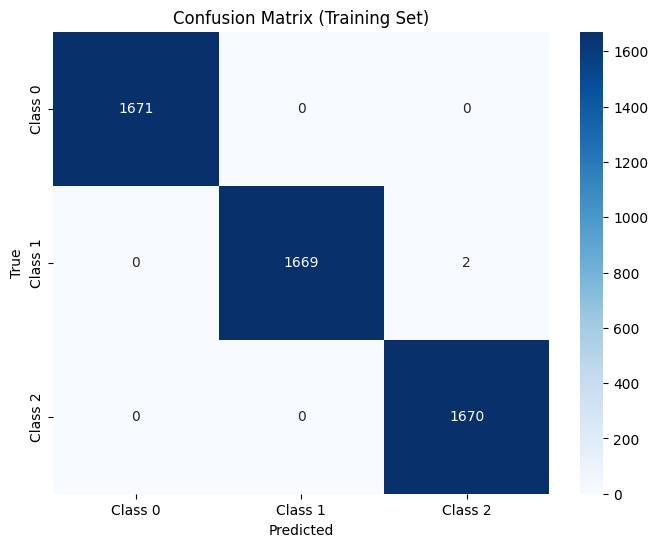

Confusion Matrix (Training Set):
[[1671    0    0]
 [   0 1669    2]
 [   0    0 1670]]

Classification Report (Training Set):
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1671
     Class 1       1.00      1.00      1.00      1671
     Class 2       1.00      1.00      1.00      1670

    accuracy                           1.00      5012
   macro avg       1.00      1.00      1.00      5012
weighted avg       1.00      1.00      1.00      5012



In [78]:
# Step 1: Get predictions on the training set
y_pred_prob = model_lstm_1.predict(X_train)  # Outputs probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)    # Convert probabilities to class labels

# Step 2: Convert true labels to class labels (if one-hot encoded)
y_true = np.argmax(y_train_ohe, axis=1) if len(y_train_ohe.shape) > 1 and y_train_ohe.shape[1] > 1 else y_train

# Step 3: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Compute precision, recall, F1-score
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your class names if available
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

# Step 5: Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Step 6: Print confusion matrix and classification report
print("Confusion Matrix (Training Set):")
print(cm)
print("\nClassification Report (Training Set):")
print(report)

Model menunjukkan performansi yang sangat baik, dengan akurasi 100%, precision, recall, dan F1-score yang semuanya mencapai 1.00 di seluruh kelas (Negative, Positive, Neutral). Tidak ada kesalahan klasifikasi yang signifikan; hanya ada 2 kesalahan pada Class 1 (Positive) yang diprediksi sebagai Class 2 (Neutral).

Tapi, kita perlu melihat apakah modelnya masih overfitting atau sudah good-fit.

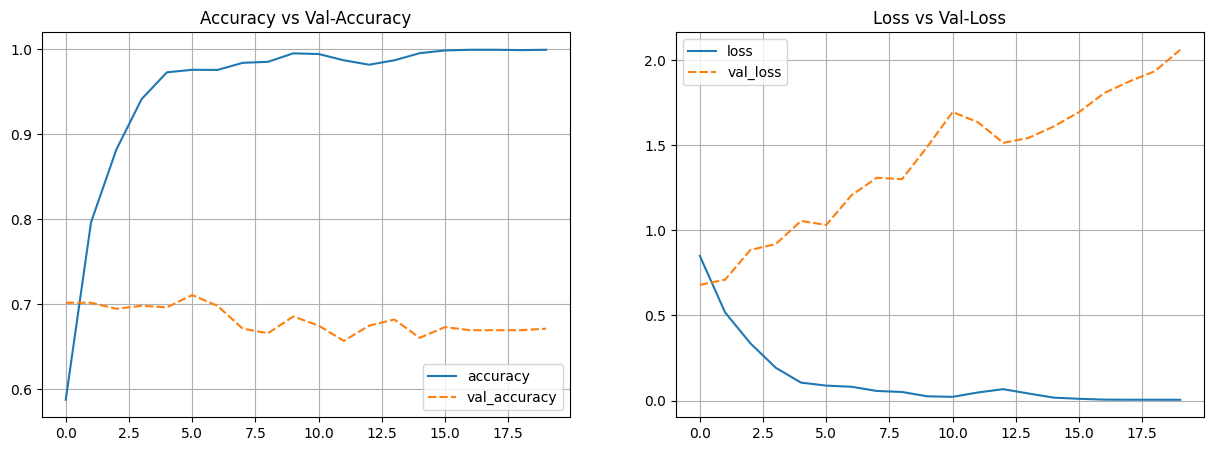

In [73]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Jika kita melihat dari hasil training model dengan *epochs*= 20, hasilnya sangat overfitting. Accuracy mencapai peak di 1.00, sedangkan val_accuracy berakhir disekitar 0.80. Bisa dilihat sempat terjadi penurunan yang sangat drastis pada accuracy mencapai 0.75.

Pada loss dan val_loss, hasil dari training loss yang terus menurun tetapi val_loss yang terus naik, ini bisa menjadi indikasi bahwa hasilnya overfit.

Ada beberapa kemungkinan yang dapat mempengaruhi hasil overfit ini. *Total Vocabulary* yang sebesar 18808 dan *Maximum Sentence Length* sebesar 1956 token tergolong besar.

Selain itu, teknik regularisasi yang dilakukan adalah hanya *dropout* sebesar 0.1. Bisa jadi, regularisasi ini belum cukup untuk mencegah model mempelajari pola yang tidak penting. Untuk mencegah overfitting, kita akan mencoba untuk melakukan *Early Stopping* sebagai salah satu cara untuk mencegah overfit. Selain itu meningkatkan score dropout dan regularisasi L1 L2 diharapkan dapat dilakukan untuk mencegah overfitting.

31/31 [==============================] - 42s 1s/step


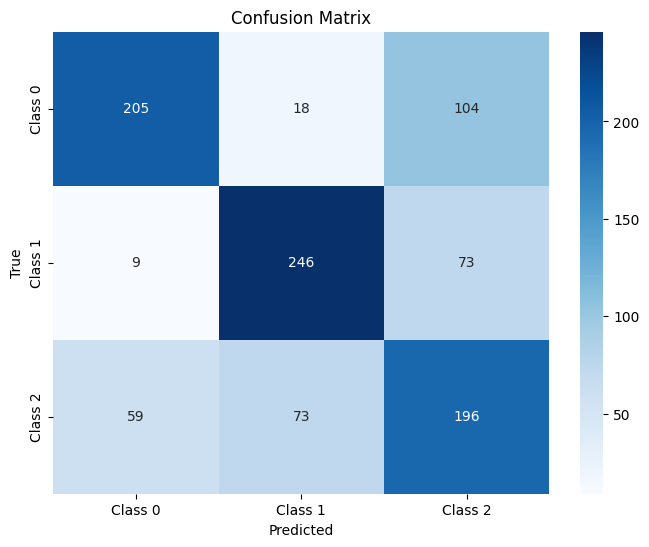

Confusion Matrix:
[[205  18 104]
 [  9 246  73]
 [ 59  73 196]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.63      0.68       327
     Class 1       0.73      0.75      0.74       328
     Class 2       0.53      0.60      0.56       328

    accuracy                           0.66       983
   macro avg       0.67      0.66      0.66       983
weighted avg       0.67      0.66      0.66       983



In [ ]:
#Get predictions on the test set
y_pred_prob = model_lstm_1.predict(X_test) 
y_pred = np.argmax(y_pred_prob, axis=1) 

#Convert true labels to class labels (if one-hot encoded)
y_true = np.argmax(y_test_ohe, axis=1) if len(y_test_ohe.shape) > 1 and y_test_ohe.shape[1] > 1 else y_test

#Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

#Compute precision, recall, F1-score
class_names = ['Class 0', 'Class 1', 'Class 2']
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

#Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Print confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Jika kita fokus dengan menggunakan recall sebagai metrics utama, maka:

- Class 0 (Negative) memiliki recall 0.63, yang berarti model hanya berhasil mengidentifikasi 63% data dalam kelas ini dengan benar. Ini menunjukkan bahwa model mungkin kesulitan untuk mendeteksi beberapa data dalam kelas Negative.

- Class 1 (Positive) memiliki recall tertinggi (0.75), yang berarti model berhasil mengidentifikasi 75% dari data sebenarnya yang termasuk dalam kelas ini dengan benar. Ini menunjukkan bahwa model sangat baik dalam mendeteksi kelas ini.

- Class 2 (Neutral) memiliki recall 0.60, yang berarti model berhasil mengenali 60% data sebenarnya dalam kelas ini. Meskipun tidak sebaik Class 1, ini menunjukkan performa yang masih cukup baik, namun ada 40% data yang terlewat atau salah diklasifikasikan.

Secara keseluruhan, dengan rata-rata recall yang mendekati 0.66, model memiliki kecenderungan untuk mengidentifikasi sebagian besar data dengan baik, tetapi masih ada ruang untuk perbaikan, terutama untuk Class 2 dan Class 0, yang memiliki recall yang lebih rendah dibandingkan dengan Class 1.

Kita akan coba melakukan model improvement dengan mengganti parameter lain, seperti menaikkan nilai dropout menjadi lebih agresif dan meningkatkan penalty dari L1 dan L2.

# Model Improvement

In [ ]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define model
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(Embedding(
    input_dim=total_vocab,
    output_dim=128,
    embeddings_initializer=tf.keras.initializers.GlorotUniform(seed)
))  # Outputs: (None, 50, 128)
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(0.02))))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(0.02))))
model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02)))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

# Train
model_lstm_2_hist = model_lstm_2.fit(
    X_train, 
    y_train_ohe, 
    epochs=20, 
    validation_data=(X_val, y_val_ohe), 
    callbacks=[early_stopping]
)

Epoch 1/20
157/157 [==============================] - 1485s 9s/step - loss: 3.5773 - accuracy: 0.4619 - val_loss: 1.2979 - val_accuracy: 0.6176
Epoch 2/20
157/157 [==============================] - 1215s 8s/step - loss: 0.9928 - accuracy: 0.6275 - val_loss: 0.8757 - val_accuracy: 0.6517
Epoch 3/20
157/157 [==============================] - 949s 6s/step - loss: 0.7472 - accuracy: 0.7197 - val_loss: 0.8919 - val_accuracy: 0.6409
Epoch 4/20
157/157 [==============================] - 855s 5s/step - loss: 0.7182 - accuracy: 0.7213 - val_loss: 0.8864 - val_accuracy: 0.6176
Epoch 5/20
157/157 [==============================] - 851s 5s/step - loss: 0.5936 - accuracy: 0.7947 - val_loss: 0.9099 - val_accuracy: 0.6750
Epoch 6/20
157/157 [==============================] - 883s 6s/step - loss: 0.5003 - accuracy: 0.8516 - val_loss: 1.0409 - val_accuracy: 0.5745
Epoch 7/20
157/157 [==============================] - 826s 5s/step - loss: 0.5311 - accuracy: 0.8494 - val_loss: 0.9533 - val_accuracy: 0.66

Pada model improvement, kita akan menaikkan nilai dropout dari 0.1 menjadi 0.3. Selain itu kita menambahkan penalty pada L1 dan L2 dari 0.01 menjadi 0.02. Kita juga akan menggunakan EarlyStopping dengan parameter yang digunakan adalah:

- `monitor=val_loss`: Parameter ini menentukan metrik yang akan dipantau untuk mendeteksi apakah model mengalami peningkatan atau tidak. Dalam hal ini, model akan memantau loss pada data validasi (val_loss). Jika val_loss tidak mengalami perbaikan selama beberapa epoch berturut-turut, pelatihan akan dihentikan.

- `patience = 5`: Menentukan jumlah epoch berturut-turut di mana pelatihan dapat dilanjutkan meskipun tidak ada perbaikan pada metrik yang dipantau (dalam hal ini, val_loss). Artinya, jika dalam 5 epoch berturut-turut val_loss tidak membaik, pelatihan akan dihentikan secara otomatis.

- `restore_best_weights=True`: Setelah pelatihan dihentikan, bobot model akan direset ke bobot terbaik yang ditemukan selama pelatihan, yaitu bobot saat val_loss mencapai nilai terendah. Ini membantu menghindari model yang overfit pada data pelatihan jika pelatihan dihentikan terlalu lama.

- `min_delta = 0.001`: Menentukan perubahan minimum yang diperlukan pada val_loss untuk dianggap sebagai perbaikan. Dalam hal ini, perbaikan val_loss harus lebih besar dari atau sama dengan 0.001 agar pelatihan dianggap mengalami peningkatan. Jika val_loss berubah kurang dari 0.001, meskipun ada perubahan, itu dianggap tidak signifikan dan tidak akan dihitung sebagai perbaikan.

157/157 [==============================] - 234s 1s/step


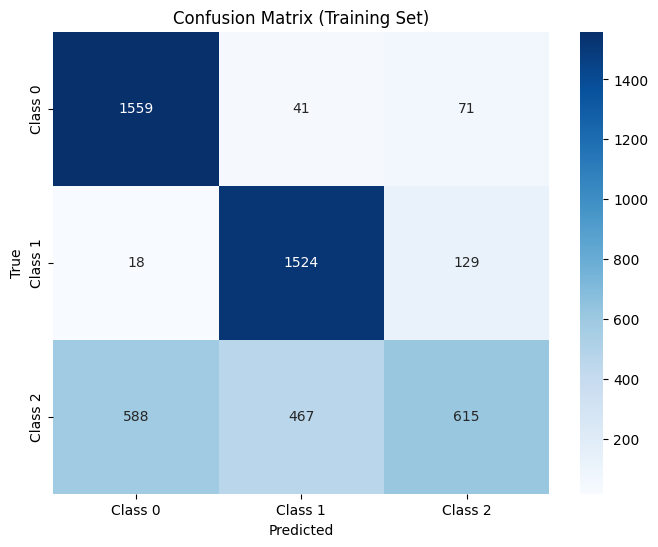

Confusion Matrix (Training Set):
[[1559   41   71]
 [  18 1524  129]
 [ 588  467  615]]

Classification Report (Training Set):
              precision    recall  f1-score   support

     Class 0       0.72      0.93      0.81      1671
     Class 1       0.75      0.91      0.82      1671
     Class 2       0.75      0.37      0.49      1670

    accuracy                           0.74      5012
   macro avg       0.74      0.74      0.71      5012
weighted avg       0.74      0.74      0.71      5012



In [79]:
# Step 1: Get predictions on the training set
y_pred_prob = model_lstm_2.predict(X_train)  # Outputs probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)    # Convert probabilities to class labels

# Step 2: Convert true labels to class labels (if one-hot encoded)
y_true = np.argmax(y_train_ohe, axis=1) if len(y_train_ohe.shape) > 1 and y_train_ohe.shape[1] > 1 else y_train

# Step 3: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Compute precision, recall, F1-score
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your class names if available
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

# Step 5: Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Step 6: Print confusion matrix and classification report
print("Confusion Matrix (Training Set):")
print(cm)
print("\nClassification Report (Training Set):")
print(report)

Pada training dengan parameter baru, kita mendapatkan bahwa:

- Class 0 dan Class 1 memiliki precision dan recall yang sangat baik, dengan recall lebih dari 90% untuk masing-masing kelas, menunjukkan bahwa model sangat efektif dalam mengidentifikasi kelas-kelas ini.

- Class 2 (Neutral) memiliki recall yang rendah (0.37), yang menunjukkan bahwa model kesulitan dalam mengidentifikasi data yang sebenarnya termasuk dalam kelas ini. Cenderung lebih buruk ketimbang pada saat test dengan model default.


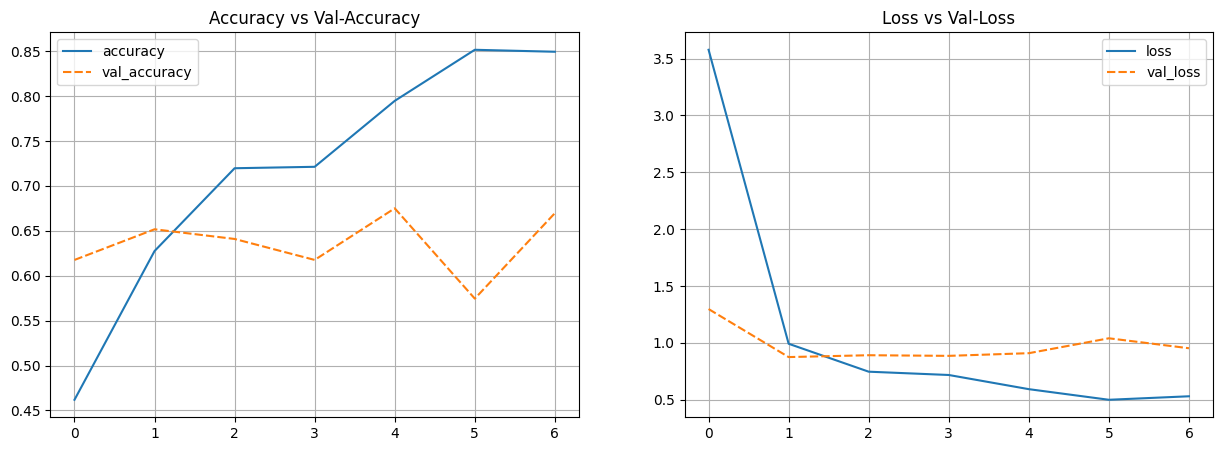

In [76]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Jika kita lihat, meskipun masih sedikit overfitting, tetapi sudah ada perbaikan yang sangat signifikan, terutama pada loss vs val-loss. Meskipun belum mencapai good-fit yang ideal, tapi kita bisa menyebut ini sebagai sebuah improvement. Bisa jadi, memang data yang imbalanced sangat berpengaruh terhadap hasil training ini.

31/31 [==============================] - 38s 1s/step


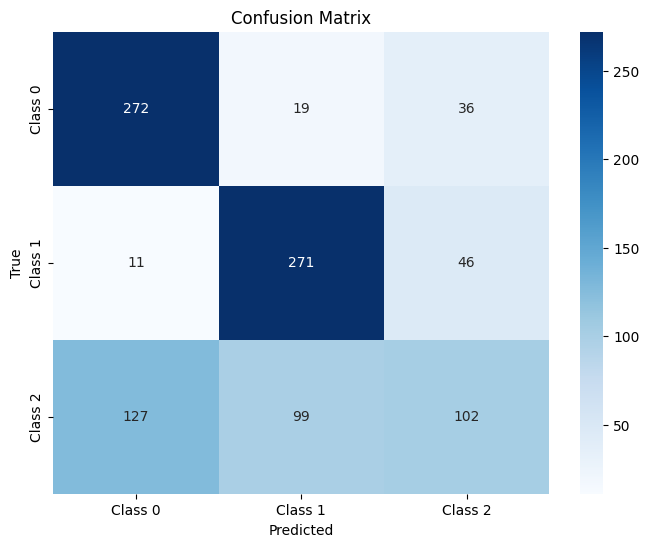

Confusion Matrix:
[[272  19  36]
 [ 11 271  46]
 [127  99 102]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.66      0.83      0.74       327
     Class 1       0.70      0.83      0.76       328
     Class 2       0.55      0.31      0.40       328

    accuracy                           0.66       983
   macro avg       0.64      0.66      0.63       983
weighted avg       0.64      0.66      0.63       983



In [ ]:
# Get predictions on the test set
y_pred_prob = model_lstm_2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels to class labels (if one-hot encoded)
y_true = np.argmax(y_test_ohe, axis=1) if len(y_test_ohe.shape) > 1 and y_test_ohe.shape[1] > 1 else y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute precision, recall, F1-score
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your class names if available
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(cm)   
print("\nClassification Report:")
print(report)

Class 0 (Negative):

- Recall: 0.83 -> Model berhasil mengidentifikasi 83% dari data yang sebenarnya termasuk dalam Class 0 (Negative).

Class 1 (Positive):

- Recall: 0.83 -> Model juga berhasil mengidentifikasi 83% dari data yang sebenarnya Class 1 (Positive).

Class 2 (Neutral):

- Recall: 0.31 -> Model hanya berhasil mengidentifikasi 31% dari data yang sebenarnya Class 2 (Neutral), yang menunjukkan model kurang efektif dalam mendeteksi kelas ini.

Apakah kita bisa mengatakan bahwa ini adalah sebuah improvement? Jika kita melihat graph line chart dan classification report pada test yang menggunakan parameter lebih agresif, kita dapat menyebut ini sebagai improvement. Karena kita fokus pada metrics recall, model mampu mengidentifikasi class 0 (Negative) sebesar 83%, jauh lebih baik ketimbang model awal.

Meskipun terjadi penurunan pada class 2 (Neutral), pada konteks sentiment analysis, terutama bagi TripAdvisor, bisnis yang bergelut dibidang hotel, tentu saja sentiment negatif jauh lebih penting dibandingkan neutral. Karena bagi perusahaan yang bekerja di bidang services, memiliki sentiment negatif tentu saja akan membuat bisnis semakin sulit.

Apalagi jika sebuah hotel terkenal memiliki sentiment negatif, maka akan sulit bagi hotel untuk memasarkan hotel mereka karena sudah mendapatkan sentimen yang buruk. Oleh karena itu, naiknya score dari 0.63 menjadi 0.83 dapat kita katakan sebagai improvement yang sangat bagus.

Mengenai accuracy, meskipun kedua model memiliki accuracy yang kurang lebih sama 66%, ini tidak menjadi masalah. Karena data yang kita miliki imbalanced, sulit untuk menggunakan accuracy sebagai metrics utama dalam menentukan apakah model sudah bagus atau belum. Sehingga dengan menggunakan classification report dengan metrics utamanya recall, lebih mudah untuk mengukur apakah model sudah bekerja dengan baik ataupun belum.

# Model Saving

In [87]:
model_lstm_2.save('model_lstm_2')

INFO:tensorflow:Assets written to: model_lstm_2\assets


INFO:tensorflow:Assets written to: model_lstm_2\assets


Setelah melakukan test antara model pertama dan kedua, kita mendapatkan bahwa model 2 memiliki improvement yang jauh lebih baik ketimbang model 1.

# Model Inference

Model Inference dilakukan pada notebook lainnya.

# Kesimpulan

- Model 1 menunjukan overfitting pada training, karena menghasilkan score yang sempurna pada classification report, yaitu 1.0. Pada data test, masih masuk dalam kategori decent, masih banyak untuk improvement.

- Model 2 menunjukan hampir good-fit, meskipun masih tergolong overfitting. Improvement terjadi pada Class 0, score recall dari 0.66 menjadi 0.83. Tetapi menjadi penurunan pada Class 2.

- Jika ingin melakukan improvement, kita dapat mengurangi layer architecture, melakukan parameter dropout atau L1 L2 lebih agresif, atau dengan melakukan transfer learning.